In [1]:
import math
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import os
import torch
import sentence_transformers
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import torch.nn as nn

from transformers import BertTokenizer, BertModel, pipeline, BartModel
from transformers import RobertaTokenizer, RobertaModel, AutoConfig

from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

from collections import OrderedDict

import textstat

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
model_name = 'roberta-base'
size = 768

In [4]:
def config_model():
    configuration = AutoConfig.from_pretrained(model_name)

    configuration.hidden_dropout_prob = 0.0
    configuration.attention_probs_dropout_prob = 0.0
    configuration.classifier_dropout = 0.0
    
    return configuration

In [5]:
# ROBERTa model

tokenizer = RobertaTokenizer.from_pretrained(model_name)
embeddings_model = RobertaModel.from_pretrained(model_name, config=config_model())
summarizer = pipeline("summarization", model="bart-large-cnn")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data

In [6]:
summaries_train_path = r"dataset\summaries_train.csv"
summaries_test_path = r"dataset\summaries_test.csv"
prompts_train_path = r"dataset\prompts_train.csv"
prompts_test_path = r"dataset\prompts_test.csv"

In [7]:
def norm_score(df: pd.DataFrame) -> pd.DataFrame:
    """Normilizing score to values 0 to 1"""
    df -= np.min(df)
    df /= df.max()
    print('Normilized' if df.min() == 0.0 and df.max() == 1.0 else 'NormError:wrong values')
    
    return df

def short_text(text, max_length=512) -> str:
    if len(text.split()) > 700:
        middle_point = text[len(text)//2:].index('.') + len(text)//2 + 1
        text_pt1 = text[:middle_point]
        text_pt2 = text[middle_point:]
        
        text = short_text(text_pt1) + short_text(text_pt2)
        
    summarized = summarizer(text, max_length=max_length, min_length=300, do_sample=False)
    
    return summarized[0]['summary_text']

def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """
    
    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))
        
    return average_array



def mean_pooling(outputs, batch) -> torch.tensor:
    
    attention_mask = batch['attention_mask']
    embeddings = outputs.last_hidden_state
    
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    
    mean_pooled = summed/summed_mask
    
    return mean_pooled

def normilize(df_column: pd.DataFrame):
    
    df_column = (df_column - df_column.mean())/df_column.std()
    
    return df_column

def get_stat_features(df, text_col="text"):
    
    df["num_unique_words"] = normilize(df[text_col].apply(lambda x: len(set(x.split()))))
    df["num_words"] = normilize(df[text_col].apply(lambda x: len(x.split())))
    df["num_sentences"] = normilize(df[text_col].apply(lambda x: len(x.split('.'))))
    
    df["syntax_count"] = normilize(df[text_col].apply(lambda x: x.count(",") 
                                                      + x.count("-") + x.count(";") + x.count(":")))
    df['smog_index'] = normilize(df[text_col].apply(lambda x: textstat.smog_index(x)))
    # df['cos_sim'] =
    
    return df

In [9]:
class SentenseData(Dataset):
    """
    :params: path to csv file with summaries, path to csv file with prompts, 'score' param\
    defines which score is used: content/wording
    """
    def __init__(self, summaries_path=summaries_train_path,
                 prompts_path=prompts_train_path,
                 score='wording', test=False, fold_test='ebad26'):
        self.test = test
        self.score_type = score
        self.fold_test = fold_test
        
        with open(summaries_path, encoding='utf-8') as f:
            summaries = pd.read_csv(f)
            summaries = get_stat_features(summaries)
            
            self.summaries = summaries
            
        with open(prompts_path, encoding='utf-8') as f:
            prompts = pd.read_csv(f)
#             prompts = prompts[prompts.prompt_id != '3b9047'].reset_index(drop=True)
            self.prompts = prompts

        
    def __len__(self):
        return len(self.__summaries)
    
    @property
    def summaries(self):
        return self.__summaries
    
    @summaries.setter
    def summaries(self, df):
        if self.test:
            self.__summaries = df[df.prompt_id == self.fold_test].reset_index(drop=True)
            
        else:
            self.__summaries = df[df.prompt_id != self.fold_test].reset_index(drop=True)
    
    @property
    def prompts(self):
        return self.__prompts
    
    @prompts.setter
    def prompts(self, file):
        self.__prompts = file
#         for i, text in enumerate(self.__prompts.prompt_text):
#             if len(text.split()) > 600:
#                 self.__prompts.prompt_text[i] = short_text(text)
    
    def get_batch_text(self, index):
        summary_text = self.summaries.text[index]
        
        if True:#self.score_type == 'wording':
            res = tokenizer(summary_text, padding='max_length', return_tensors='pt', truncation=True)
            res = {k:val.squeeze() for k, val in res.items()}
            res['features'] = torch.tensor([self.summaries['num_unique_words'][index], self.summaries['num_words'][index],
                                  self.summaries['num_sentences'][index],self.summaries['syntax_count'][index],
                                  self.summaries['smog_index'][index]], dtype=torch.float32)
            
            return res
            
        prompt_text = self.prompts.prompt_text[self.prompts.prompt_id ==
                                               self.summaries.prompt_id[index]].item().replace('\n','')
        
        return tokenizer([summary_text, prompt_text], padding='max_length', return_tensors='pt', truncation=True)
    
    def get_score(self, index):
        if self.score_type == 'content':
            score = self.summaries.content[index]
            
        elif self.score_type == 'wording':
            score = self.summaries.wording[index]
        
        return torch.tensor(score)
        
    def __getitem__(self, index) -> torch.tensor:

        batch_text = self.get_batch_text(index)
        batch_score = self.get_score(index)
        
        return batch_text, batch_score

## Model

In [9]:
class STSBertModel(nn.Module):
    """
    Sentence Semantic Similarity Bert model
    :param: seg_head=True for using segmentation head instead of cosine similarity
    :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
    """
    def __init__(self, with_features=False, input_size=size):
        super(STSBertModel, self).__init__()
        
        self.word_embedding = RobertaModel.from_pretrained(model_name, config=config_model())
        self.cos_score = nn.CosineSimilarity(dim=0)
        self.identity = nn.Identity()
        self.input_size = input_size
        self.with_features = with_features

        if with_features:
            self.n_features = 5
            self.input_size += self.n_features

        # for param in self.word_embedding.parameters():
        #     param.requires_grad = False

        self.attention = SelfAttention(self.input_size)
        self.block = AttentionBlock(input_size)

        self.FC_head = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, 1024)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(1024, self.input_size)),
            ('relu2', nn.ReLU())
            ]))

        self.FC_output = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, 1)),
            ]))
    
    def forward(self, x):
        output = self.word_embedding(input_ids=x['input_ids'], attention_mask=x['attention_mask'])
        output = mean_pooling(output, x)
        
        if self.with_features:            
            output = torch.cat((output, x['features']), dim=1)

        identity = output.unsqueeze(1)

        output = self.attention(identity)
        output = self.FC_head(output)

        output = self.attention(output)
        output = self.FC_head(output)

        output = self.attention(output)
        output = self.FC_output(output)
        
        return output

In [10]:
class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()

        self.input_dim = input_dim
        self.fc = nn.Linear(input_dim, input_dim)
        self.attention = SelfAttention(input_dim)
        self.relu = nn.ReLU()
        self.norm = nn.BatchNorm2d()

    def forward(self, x):
        identity = x

        x = self.attention(x)
        x = self.fc(x)

        x += identity
        x = self.norm(x)
        x = self.relu(x)

        return x

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted
    

In [10]:
# class STSBertModel(nn.Module):
#     """
#     Sentence Semantic Similarity Bert model
#     :param: seg_head=True for using segmentation head instead of cosine similarity
#     :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
#     """
#     def __init__(self, seg_head=False, freeze_weights=False, input_size=768):
#         super(STSBertModel, self).__init__()
        
#         self.word_embedding = RobertaModel.from_pretrained('roberta-base', config=config_model())
#         self.cos_sim = nn.CosineSimilarity(dim=0)
#         self.identity = nn.Identity()
#         self.seg_head = seg_head
#         self.fc = nn.Sequential(OrderedDict([
#             ('fc1', nn.Linear(input_size*2, 1024)),
#             ('tanh', nn.Tanh()),
#             ('fc2', nn.Linear(1024, 256)),
#             ('tanh', nn.Tanh()),
#             ('output', nn.Linear(256, 1)),
#         ]))
        
        
#         if seg_head:
# #             self.FC_head = SbertHead(inputs=768)
#             self.FC_head = nn.Sequential(OrderedDict([
# #                 ('dropout1', nn.Dropout(0.2)),
#                 ('fc_input', nn.Linear(input_size, 1024)),
#                 ('relu1', nn.ReLU()),
#                 ('fc1', nn.Linear(1024,1024)),
# #                 ('dropout2', nn.Dropout(0.2)),
# #                 ('batch_norm1', nn.BatchNorm1d(1024)),
#                 ('relu2', nn.ReLU()),
#                 ('fc2', nn.Linear(1024, 512)),
#                 ('relu3', nn.ReLU()),
# #                 ('dropout2', nn.Dropout(0.2)),
#                 ('fc3', nn.Linear(512, 512)),
# #                 ('batch_norm2', nn.BatchNorm1d(512)),
#                 ('relu4', nn.ReLU()),
#                 ('fc4', nn.Linear(512, 256)),
# #                 ('batch_norm3', nn.BatchNorm1d(256)),
#                 ('relu5', nn.ReLU()),
# #                 ('dropout3', nn.Dropout(0.2)),
#                 ('fc5', nn.Linear(256, 64)),
#                 ('relu6', nn.ReLU()),
#                 ('fc_output', nn.Linear(64, 1))
# #                 ('activation', nn.Sigmoid())
#             ]))
            
#         if freeze_weights:
#             self.freeze()
    
#     def freeze(self):
#         for param in self.word_embedding.parameters():
#             param.requires_grad = False
    
#     @staticmethod
#     def mean_pooling(outputs, batch) -> torch.tensor:
        
#         attention_mask = batch['attention_mask']
#         embeddings = outputs.last_hidden_state
    
#         mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
#         masked_embeddings = embeddings * mask
    
#         summed = torch.sum(masked_embeddings, 1)
#         summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    
#         mean_pooled = summed/summed_mask
    
#         return mean_pooled
    
#     def cos_score(self, x):
#         embedding_1 = x[0]
#         embedding_2 = x[1]
#         emb = torch.concat((embedding_1, embedding_2))
        
        
        
#         cos_score = self.fc(emb)
        
# #         cos_score = self.cos_sim(embedding_1, embedding_2)
# #         cos_score = torch.sigmoid(cos_score)
        
#         return cos_score
    
#     def forward(self, x):
#         output = self.word_embedding(**x)
#         output = self.mean_pooling(output, x)
# #         output = output[1]
        
#         if self.seg_head:
#             output = self.FC_head(output)
        
#         else:
#             output = self.cos_score(output)
        
#         return output

In [ ]:
# score_type = 'wording'
# batch_size = 15

# test_data = SentenseData(test=True, score=score_type)
# train_data = SentenseData(score=score_type)

# train_loader = DataLoader(train_data,
#                            batch_size=batch_size,
#                            shuffle=True)

# test_loader = DataLoader(test_data,
#                           batch_size=batch_size,
#                           shuffle=True)

## Training

In [ ]:
# model = STSBertModel(seg_head=True, freeze_weights=False)

# model.float()

# model.to(device)

In [ ]:
# Loss_func = nn.MSELoss()

# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-06, weight_decay=2e-04)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

# scaler = torch.cuda.amp.GradScaler()

In [11]:
def validate_model(model, loss_func):

    losses_epoch_test = []
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.float().to(device)
            if True:
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}
                
                with torch.no_grad():
                    outputs = model(inputs)
                    
            else:
                outputs = torch.stack([model(sentence.to(device)) for sentence in inputs])


            loss = torch.sqrt(loss_func(outputs.squeeze(), targets))

            
            losses_epoch_test.append(loss.item())
    
    return losses_epoch_test

def train_model(n_epochs, lr, weight_decay, n_fold):
    
    model = STSBertModel(with_features=True)
    
    model.float()
    model.to(device)
    
    params = [
        {'params': model.word_embedding.parameters()},
        {'params': model.attention.parameters(), 'lr': 5e-05},
        {'params': model.FC_head.parameters(), 'lr': 5e-05},
        {'params': model.FC_output.parameters(), 'lr': 5e-05}
    ]
    
    loss_func = nn.MSELoss()
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)
    scaler = torch.cuda.amp.GradScaler()
    
    losses_train = []
    losses_test = []
    t0 = datetime.now()

    for i in range(n_epochs):
    
        losses_train_per_epoch = []
    
        for j, batch in enumerate(tqdm(train_loader, position=0, leave=True), 1):
            inputs, targets = batch
            targets = targets.float().to(device)
        
            model.train()
        
            optimizer.zero_grad()
        
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}
                outputs = model(inputs)
            
                loss = torch.sqrt(loss_func(outputs.squeeze(), targets))
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
        
            scaler.update()
        
            losses_train_per_epoch.append(loss.item())
        
            if j%30 == 0 or j == len(train_loader):
            
                losses_test_per_epoch = validate_model(model, loss_func)
                losses_test_mean = np.mean(losses_test_per_epoch)
                losses_train_mean = np.mean(losses_train_per_epoch)
            
                losses_train.append(losses_train_mean)
                losses_test.append(losses_test_mean)
            
                if losses_test_mean == np.min(losses_test):
                    best_score = losses_test_mean
                    n_iter = len(losses_train)
                    torch.save(model.state_dict(), r'models\cv\best__fold_{}.pt'.format(n_fold))
                    print(f'Best saved, loss: {best_score:.5f}')
                
                print(f'Fold# {n_fold}, Epoch: {i+1}/{n_epochs}, L_train: {losses_train_mean:.5f},\
                L_test: {losses_test_mean:.5f}') 
            
        torch.cuda.empty_cache()

    print(f"Time elapsed:{datetime.now()-t0}, Best score:{best_score:.5f}")
    
    return best_score, n_iter, losses_test, losses_train

## CV

In [12]:
def loaders_init(score_type, batch_size, fold):
    
    test_data = SentenseData(test=True, score=score_type, fold_test=fold)
    train_data = SentenseData(score=score_type, fold_test=fold)
    
    train_loader = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True, drop_last=True)

    test_loader = DataLoader(test_data,
                          batch_size=batch_size,
                          shuffle=True, drop_last=True)
    
    return train_loader, test_loader

def axis_set(ax):

    ax.plot(test_losses, label='test')
    ax.plot(train_losses, label='train')
    ax.scatter(n_iter - 1, best_score, label='min')
    ax.set_title(f'#{i}, min: {best_score:.5f}', loc='left')
    ax.xaxis.set_major_locator(ticker.LinearLocator(n_epochs + 1))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
    ax.legend()

    return ax

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 30/1021 [03:44<15:00:02, 54.49s/it]

Best saved, loss: 1.00661
Fold# 1, Epoch: 1/5, L_train: 0.96669,                L_test: 1.00661


  6%|▌         | 60/1021 [06:05<8:42:41, 32.63s/it] 

Best saved, loss: 0.95040
Fold# 1, Epoch: 1/5, L_train: 0.91891,                L_test: 0.95040


  9%|▉         | 90/1021 [09:43<14:35:51, 56.45s/it]

Best saved, loss: 0.80953
Fold# 1, Epoch: 1/5, L_train: 0.88350,                L_test: 0.80953


 12%|█▏        | 120/1021 [14:44<20:41:42, 82.69s/it]

Best saved, loss: 0.61838
Fold# 1, Epoch: 1/5, L_train: 0.84411,                L_test: 0.61838


 15%|█▍        | 150/1021 [19:01<16:57:02, 70.06s/it]

Fold# 1, Epoch: 1/5, L_train: 0.81245,                L_test: 0.72506


 18%|█▊        | 180/1021 [20:26<4:15:15, 18.21s/it] 

Best saved, loss: 0.58555
Fold# 1, Epoch: 1/5, L_train: 0.78899,                L_test: 0.58555


 21%|██        | 210/1021 [21:49<3:56:53, 17.53s/it]

Fold# 1, Epoch: 1/5, L_train: 0.77142,                L_test: 0.61118


 24%|██▎       | 240/1021 [23:13<3:55:09, 18.07s/it]

Best saved, loss: 0.56877
Fold# 1, Epoch: 1/5, L_train: 0.76294,                L_test: 0.56877


 26%|██▋       | 270/1021 [26:21<10:14:29, 49.09s/it]

Fold# 1, Epoch: 1/5, L_train: 0.74915,                L_test: 0.60599


 29%|██▉       | 300/1021 [29:54<11:26:29, 57.13s/it]

Fold# 1, Epoch: 1/5, L_train: 0.73808,                L_test: 0.69905


 32%|███▏      | 329/1021 [31:54<1:07:07,  5.82s/it] 


KeyboardInterrupt: 

<Figure size 1200x400 with 0 Axes>

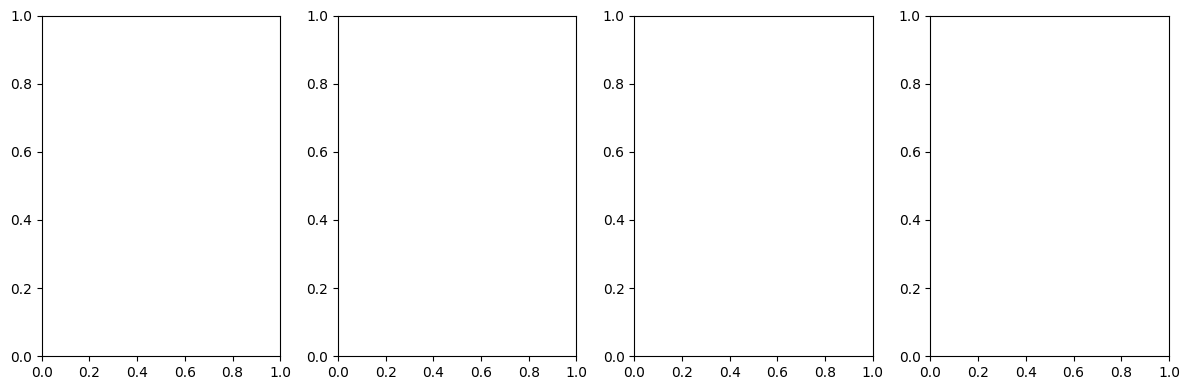

In [13]:
# def cross_validation():
with open(prompts_train_path, encoding='utf-8') as f:
    prompts = pd.read_csv(f)
#     prompts = prompts[prompts.prompt_id != '3b9047'].reset_index(drop=True)
    
plt.figure(figsize=(12,4))

folds_list = list(prompts.prompt_id)
score_type = 'wording'
batch_size = 5
lr = 2e-06
weight_decay = 2e-02

n_epochs = 5

scores = []

fig, axs = plt.subplots(1, len(folds_list), figsize=(12,4), layout='tight')

for i, fold in enumerate(folds_list, 1):
    train_loader, test_loader = loaders_init(score_type, batch_size, fold)
    
    best_score, n_iter, test_losses, train_losses = train_model(n_epochs, lr, weight_decay, i)
    
    scores.append(best_score)
    
    axs[i-1] = axis_set(axs[i-1])
    
#     plt.subplot(1, 4, i)
#     plt.plot(test_losses, label='test')
#     plt.plot(train_losses, label='train')
#     plt.scatter(n_iter - 1, best_score, label='min')
#     plt.legend()
#     plt.title(f'#{i}, min: {best_score:.5f}')
#     plt.tight_layout()
    
mean_score = np.mean(scores)

fig.suptitle(f'{mean_score:.5f}')
fig.savefig('res_figure.png', dpi=200)

mean_score

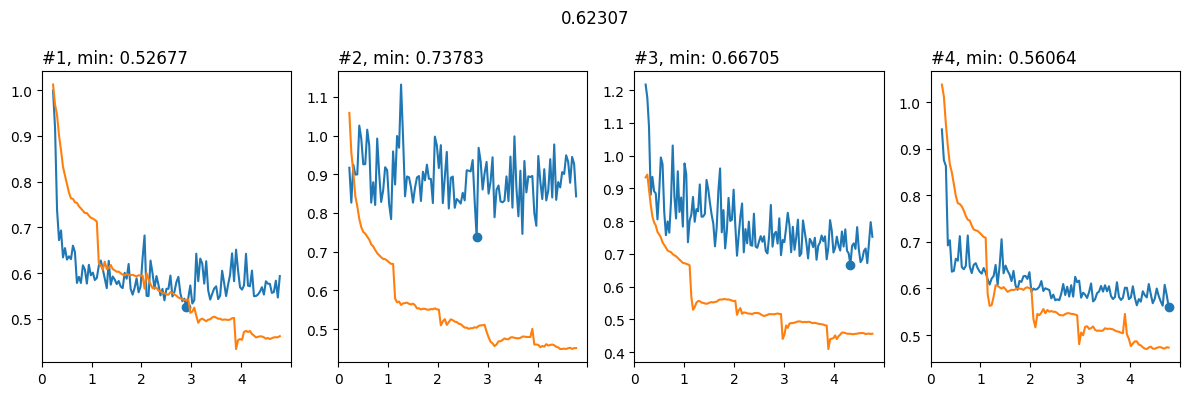

In [24]:
fig.suptitle(f'{mean_score:.5f}')

In [26]:
fig.savefig('res_figure.png', dpi=200)

In [ ]:
# fig, axs = plt.subplots(1, len(fold_list), figsize=(12,4), layout='tight')

# axs[i].plot(test_losses, label='test')
# axs[i].plot(train_losses, label='train')
# axs[i].scatter(n_iter - 1, best_score, label='min')
# axs[i].set_title(f'#{i}, min: {best_score:.5f}', loc=left)
# axs[i].xaxis.set_major_locator(ticker.LinearLocator(n_epochs + 1))
# axs[i].xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))

In [1]:
scores

NameError: name 'scores' is not defined

In [16]:
torch.cuda.empty_cache()

In [13]:
folds_list

['39c16e', '814d6b', 'ebad26']